<h1>Dask dataframe</h1>
<h3>Data Prep</h3>

In [1]:
# %run prep_data.py -d flights

In [1]:
import os
import dask.dataframe as dd
import pandas as pd

In [2]:
import os
files = os.path.join('data', 'nycflights', '*.csv')
files

'data/nycflights/*.csv'

In [3]:
ddf = dd.read_csv(files,
                  dtype={"TailNum": str,
                        "CRSElapsedTime": float,
                        "Cancelled": bool,
                        "DepDelay": float})
ddf

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,string,int64,string,float64,float64,float64,float64,float64,string,string,float64,float64,float64,bool,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [4]:
# ddf[['Year', 'Month', 'DayofMonth']] = ddf[['Year', 'Month', 'DayofMonth']].astype(int)

In [5]:
def create_pdf(pdf):
    return pd.to_datetime(
        dict(year=pdf['Year'], month=pdf['Month'], day=pdf['DayofMonth']),
        format='%Y-%m-%d'
    )

In [6]:
ddf['Date'] = ddf.map_partitions(
    create_pdf,
    meta=('Date', 'datetime64[ns]')
)

In [7]:
ddf.columns

Index(['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'DepTime', 'CRSDepTime',
       'ArrTime', 'CRSArrTime', 'UniqueCarrier', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Origin', 'Dest', 'Distance', 'TaxiIn', 'TaxiOut',
       'Cancelled', 'Diverted', 'Date'],
      dtype='object')

In [8]:
ddf.dtypes

Year                           int64
Month                          int64
DayofMonth                     int64
DayOfWeek                      int64
DepTime                      float64
CRSDepTime                     int64
ArrTime                      float64
CRSArrTime                     int64
UniqueCarrier        string[pyarrow]
FlightNum                      int64
TailNum              string[pyarrow]
ActualElapsedTime            float64
CRSElapsedTime               float64
AirTime                      float64
ArrDelay                     float64
DepDelay                     float64
Origin               string[pyarrow]
Dest                 string[pyarrow]
Distance                     float64
TaxiIn                       float64
TaxiOut                      float64
Cancelled                       bool
Diverted                       int64
Date                  datetime64[ns]
dtype: object

In [9]:
ddf.npartitions

10

In [10]:
ddf.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted,Date
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,46.0,41.0,EWR,PIT,319.0,NaN,NaN,False,0,1990-01-01
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,False,0,1990-01-02
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,9.0,6.0,EWR,PIT,319.0,NaN,NaN,False,0,1990-01-03
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,9.0,2.0,EWR,PIT,319.0,NaN,NaN,False,0,1990-01-04
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,5.0,9.0,EWR,PIT,319.0,NaN,NaN,False,0,1990-01-05


<h3>Pandas vs Dask</h3> Speed comparison

In [11]:
ddf.isna().sum().compute()

Year                       0
Month                      0
DayofMonth                 0
DayOfWeek                  0
DepTime                70931
CRSDepTime                 0
ArrTime                78210
CRSArrTime                 0
UniqueCarrier              0
FlightNum                  0
TailNum              1313006
ActualElapsedTime      78210
CRSElapsedTime          1965
AirTime              1356823
ArrDelay               78210
DepDelay               70931
Origin                     0
Dest                       0
Distance                1495
TaxiIn               1313006
TaxiOut              1313006
Cancelled                  0
Diverted                   0
Date                       0
dtype: int64

In [12]:
ddf['DepDelay'] = ddf['DepDelay'].fillna(0)
max_delay = ddf['DepDelay'].max()

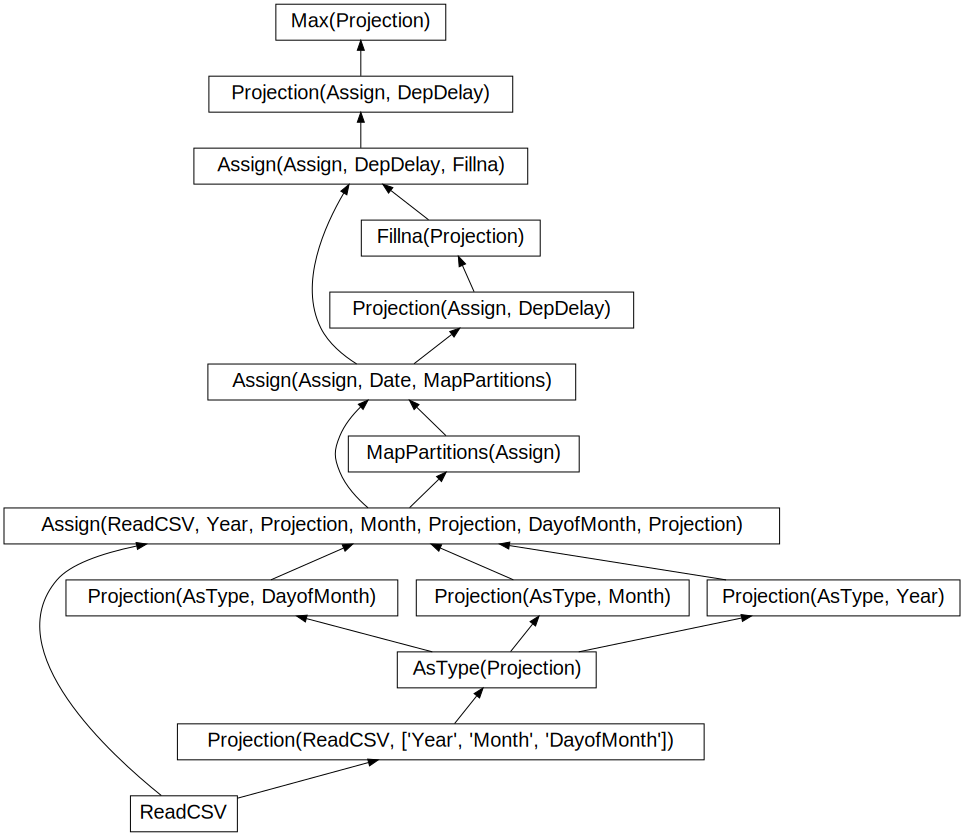

In [13]:
max_delay.visualize()

In [14]:
%%time
max_delay.compute()

CPU times: user 1.75 s, sys: 48.5 ms, total: 1.79 s
Wall time: 1.03 s


np.float64(1435.0)

In [16]:
%%time
# Pandas code to find maximum delay of files
import pandas as pd

files = os.listdir(os.path.join('data', 'nycflights'))

maxes = []

for file in files:
    df = pd.read_csv(os.path.join('data', 'nycflights', file))
    maxes.append(df.DepDelay.max())

final_max = max(maxes)
final_max

CPU times: user 2.07 s, sys: 89.7 ms, total: 2.16 s
Wall time: 2.17 s


np.float64(1435.0)

In [5]:
# Total non-cancelled flights
(~ddf['Cancelled']).sum().compute()

np.int64(2540961)

In [6]:
ddf[~ddf['Cancelled']].groupby('Origin')['Origin'].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

In [7]:
# Average departure delay from each airport
ddf.groupby('Origin')['DepDelay'].mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

In [8]:
# What day of the week has the worst departure delay
ddf.groupby("DayOfWeek")['DepDelay'].mean().idxmax().compute()

np.int64(5)

<h4>Map Partitions</h4>

In [22]:
def sub_2(df):
    return df.apply(lambda x: x-2)

ddf['AdjustedDepDelay'] = ddf['DepDelay'].map_partitions(sub_2, meta=("AdjustedDepDelay", "int"))

ddf[['AdjustedDepDelay', 'DepDelay']].head()

,AdjustedDepDelay,DepDelay
0,39.0,41.0
1,5.0,7.0
2,4.0,6.0
3,0.0,2.0
4,7.0,9.0


In [10]:
# Tips to performance improvement with 'compute' method

non_cancelled = ddf[~ddf['Cancelled']]
mean_delay = non_cancelled['DepDelay'].mean()
std_delay = non_cancelled['DepDelay'].std()

In [11]:
%%time

mean_delay_result = mean_delay.compute()
std_delay_result = std_delay.compute()

CPU times: user 3.63 s, sys: 117 ms, total: 3.75 s
Wall time: 2.29 s


In [12]:
mean_delay_result, std_delay_result

(np.float64(9.206602541321965), np.float64(28.974539774551456))

In [13]:
# Repeat above computations with task graph merging
import dask

In [14]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 4.58 s, sys: 731 ms, total: 5.31 s
Wall time: 3.84 s


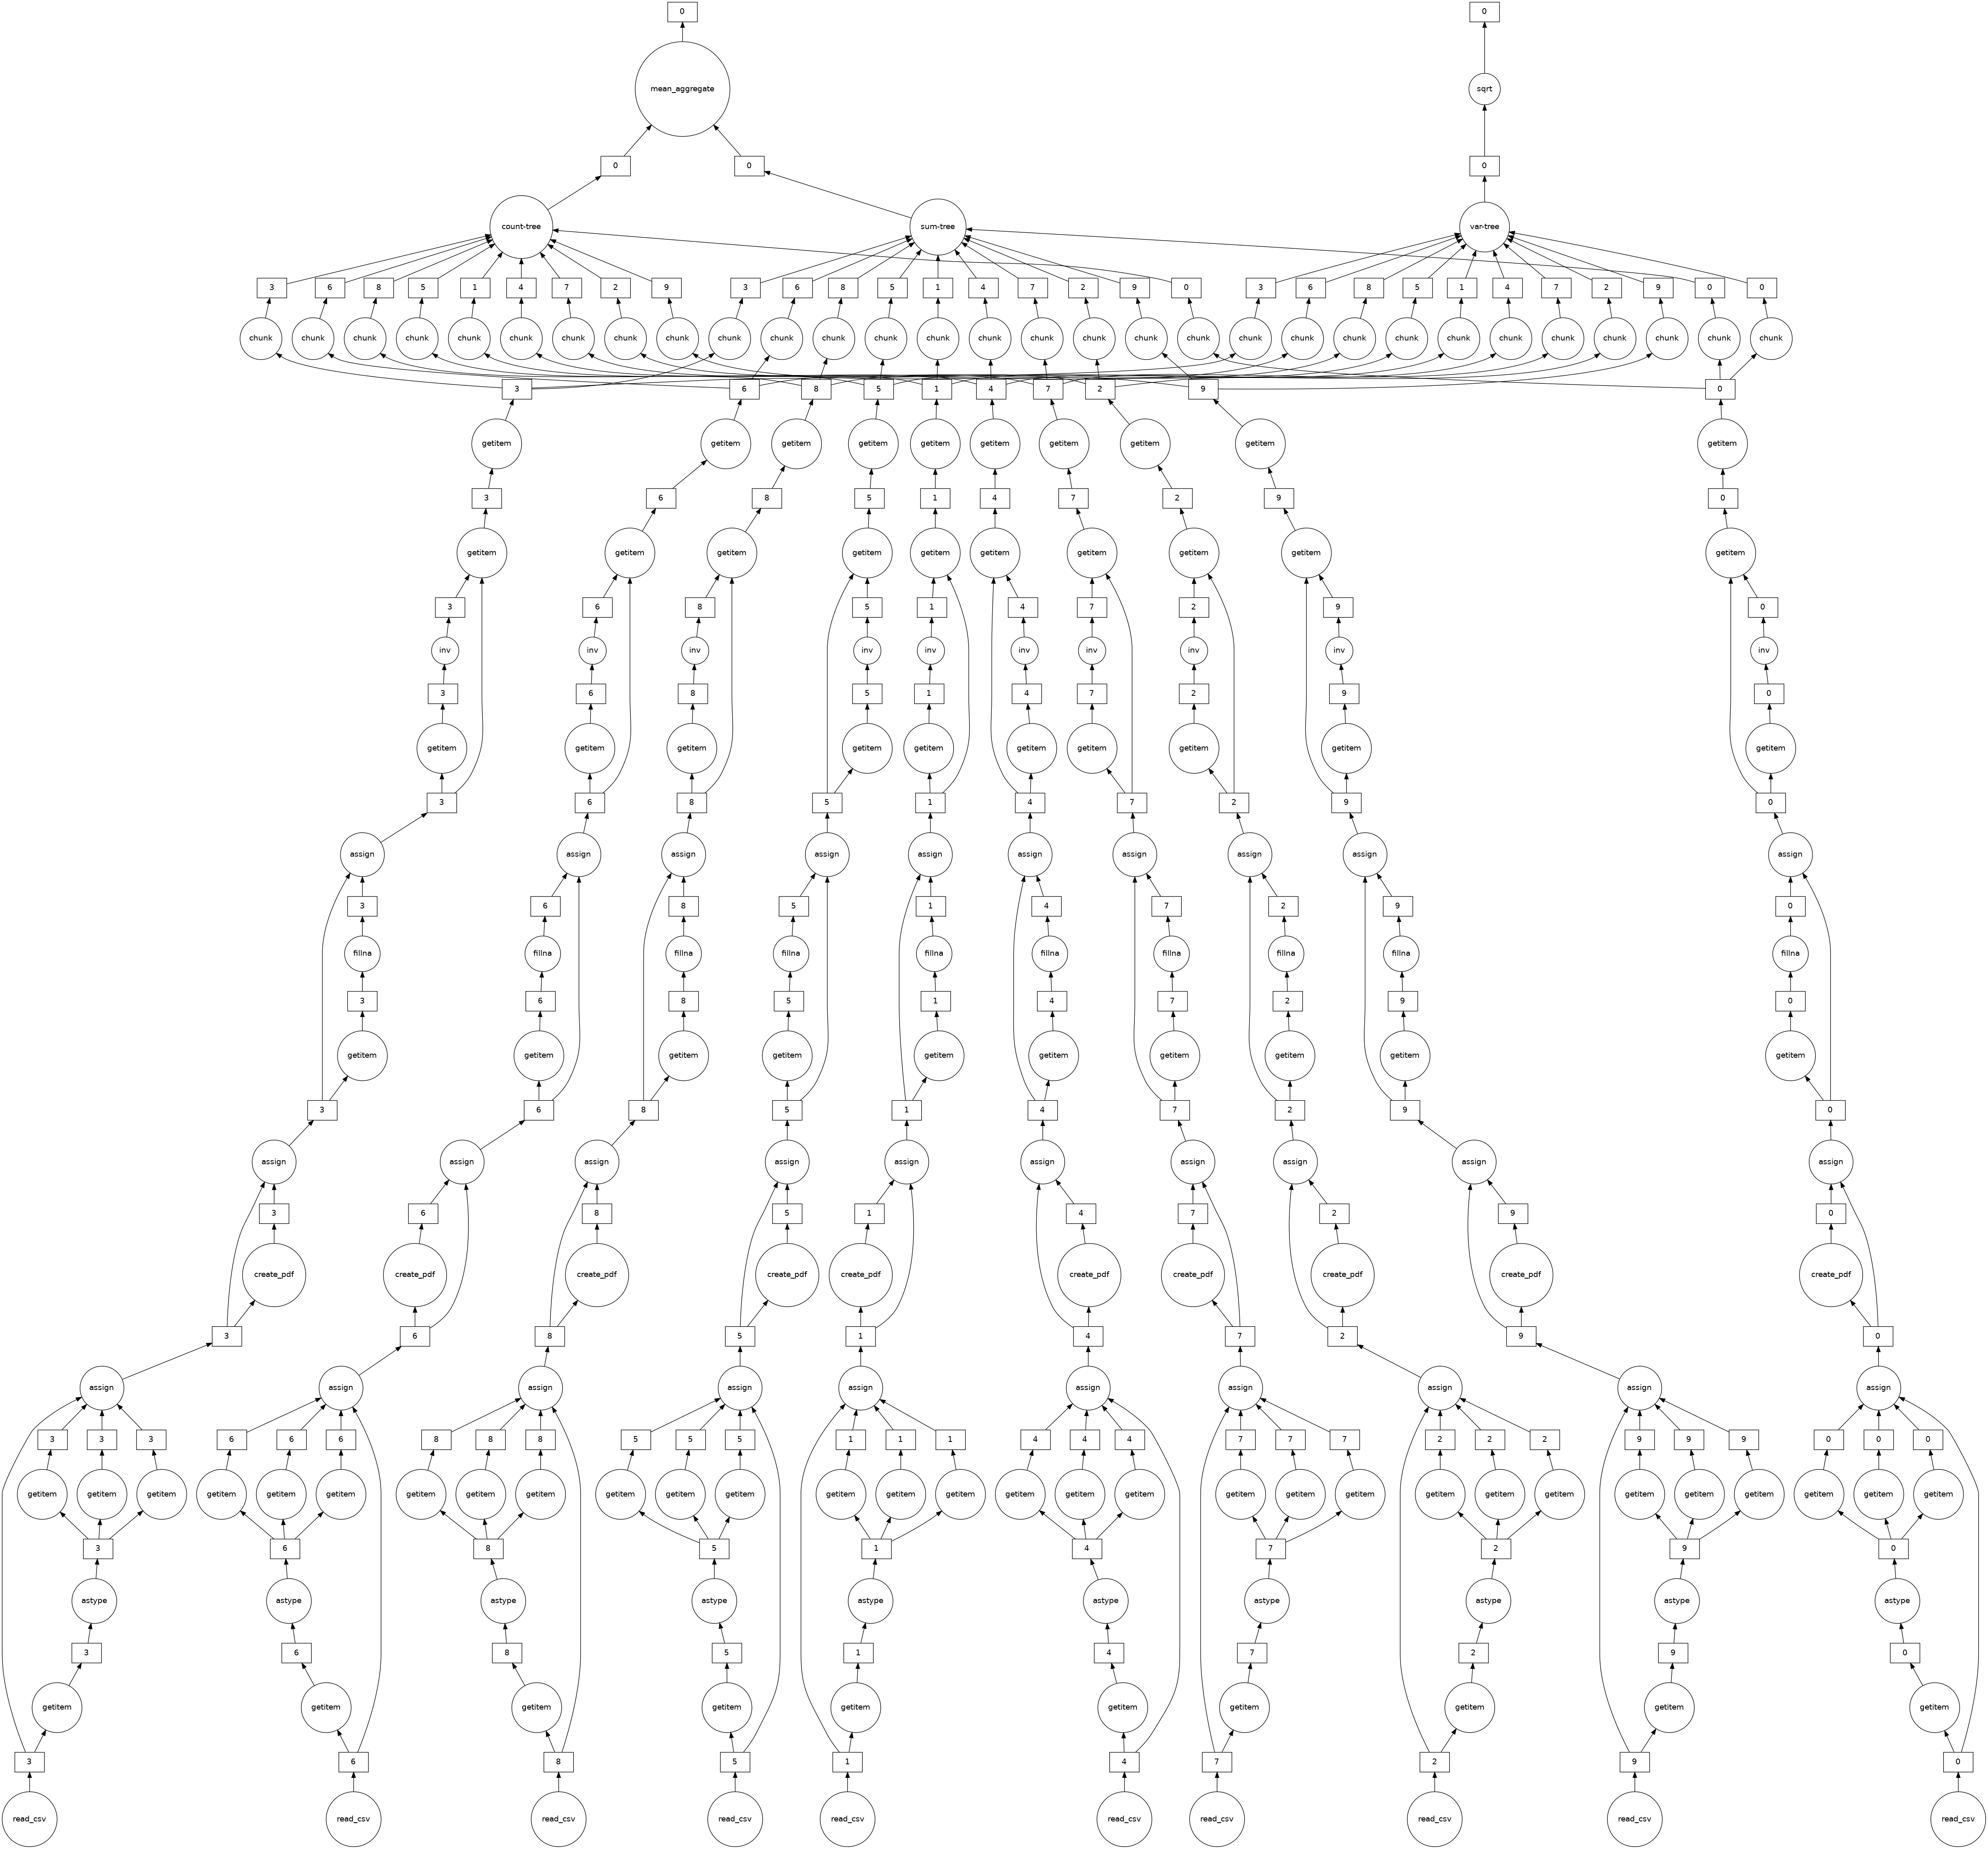

In [20]:
dask.visualize(mean_delay, std_delay)